In [1]:
from utils import *
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data_dir = "data/flowers"
shrink_dataset(data_dir, 80)

daisy Reduced to 80
dandelion Reduced to 80
rose Reduced to 80
sunflower Reduced to 80
tulip Reduced to 80


In [3]:
img_size = (224, 224)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=80,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

valid_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

In [4]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_test_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
)

test_generator = valid_test_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
)

Found 280 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


In [5]:
class_indices = train_generator.class_indices
print(f"Class indices: {class_indices}")

Class indices: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [6]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

images, labels = next(train_generator)

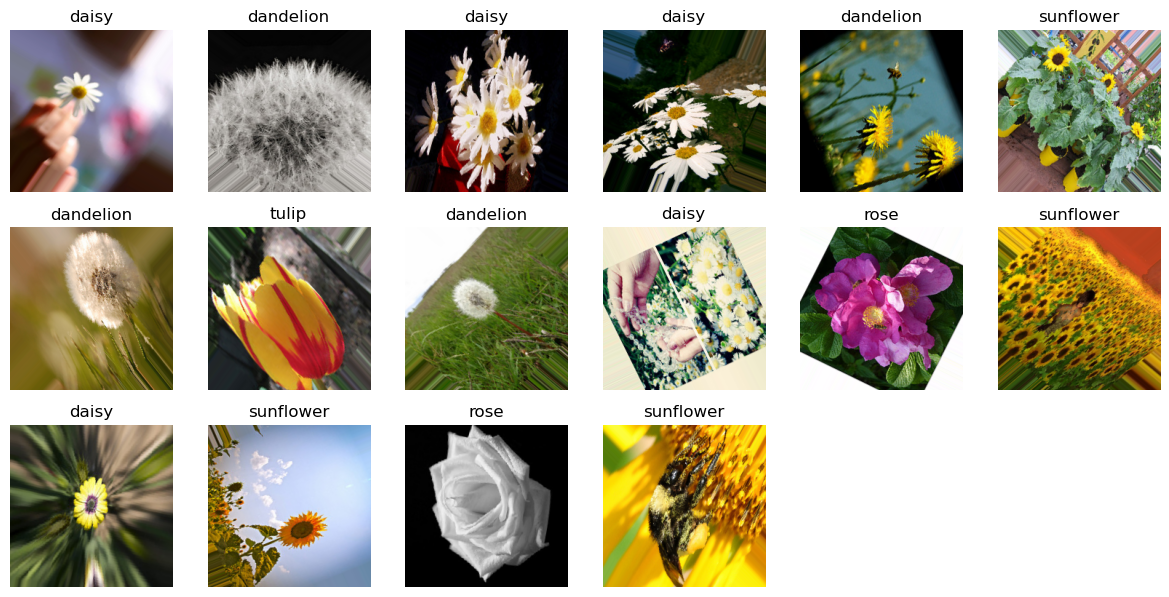

In [7]:
show_images(images, labels, class_names)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [10]:
model.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/20
18/18 [==============================] - 8s 417ms/step - loss: 4.6411 - accuracy: 0.2321 - val_loss: 3.2372 - val_accuracy: 0.2600
Epoch 2/20
18/18 [==============================] - 8s 423ms/step - loss: 2.7350 - accuracy: 0.2750 - val_loss: 2.3160 - val_accuracy: 0.2750
Epoch 3/20
18/18 [==============================] - 7s 409ms/step - loss: 2.0695 - accuracy: 0.3214 - val_loss: 1.8197 - val_accuracy: 0.3900
Epoch 4/20
18/18 [==============================] - 7s 405ms/step - loss: 1.7526 - accuracy: 0.3857 - val_loss: 1.5724 - val_accuracy: 0.4850
Epoch 5/20
18/18 [==============================] - 7s 407ms/step - loss: 1.6801 - accuracy: 0.4107 - val_loss: 1.5549 - val_accuracy: 0.5000
Epoch 6/20
18/18 [==============================] - 8s 413ms/step - loss: 1.6029 - accuracy: 0.4071 - val_loss: 1.4457 - val_accuracy: 0.4900
Epoch 7/20
18/18 [==============================] - 8s 419ms/step - loss: 1.5148 - accuracy: 0.4464 - val_loss: 1.3686 - val_accuracy: 0.5100
Epoch 

In [11]:
model.evaluate(test_generator)

13/13 [==============================] - 1s 62ms/step - loss: 1.3115 - accuracy: 0.5250


[1.311517596244812, 0.5249999761581421]

1/1 [==============================] - 0s 287ms/step


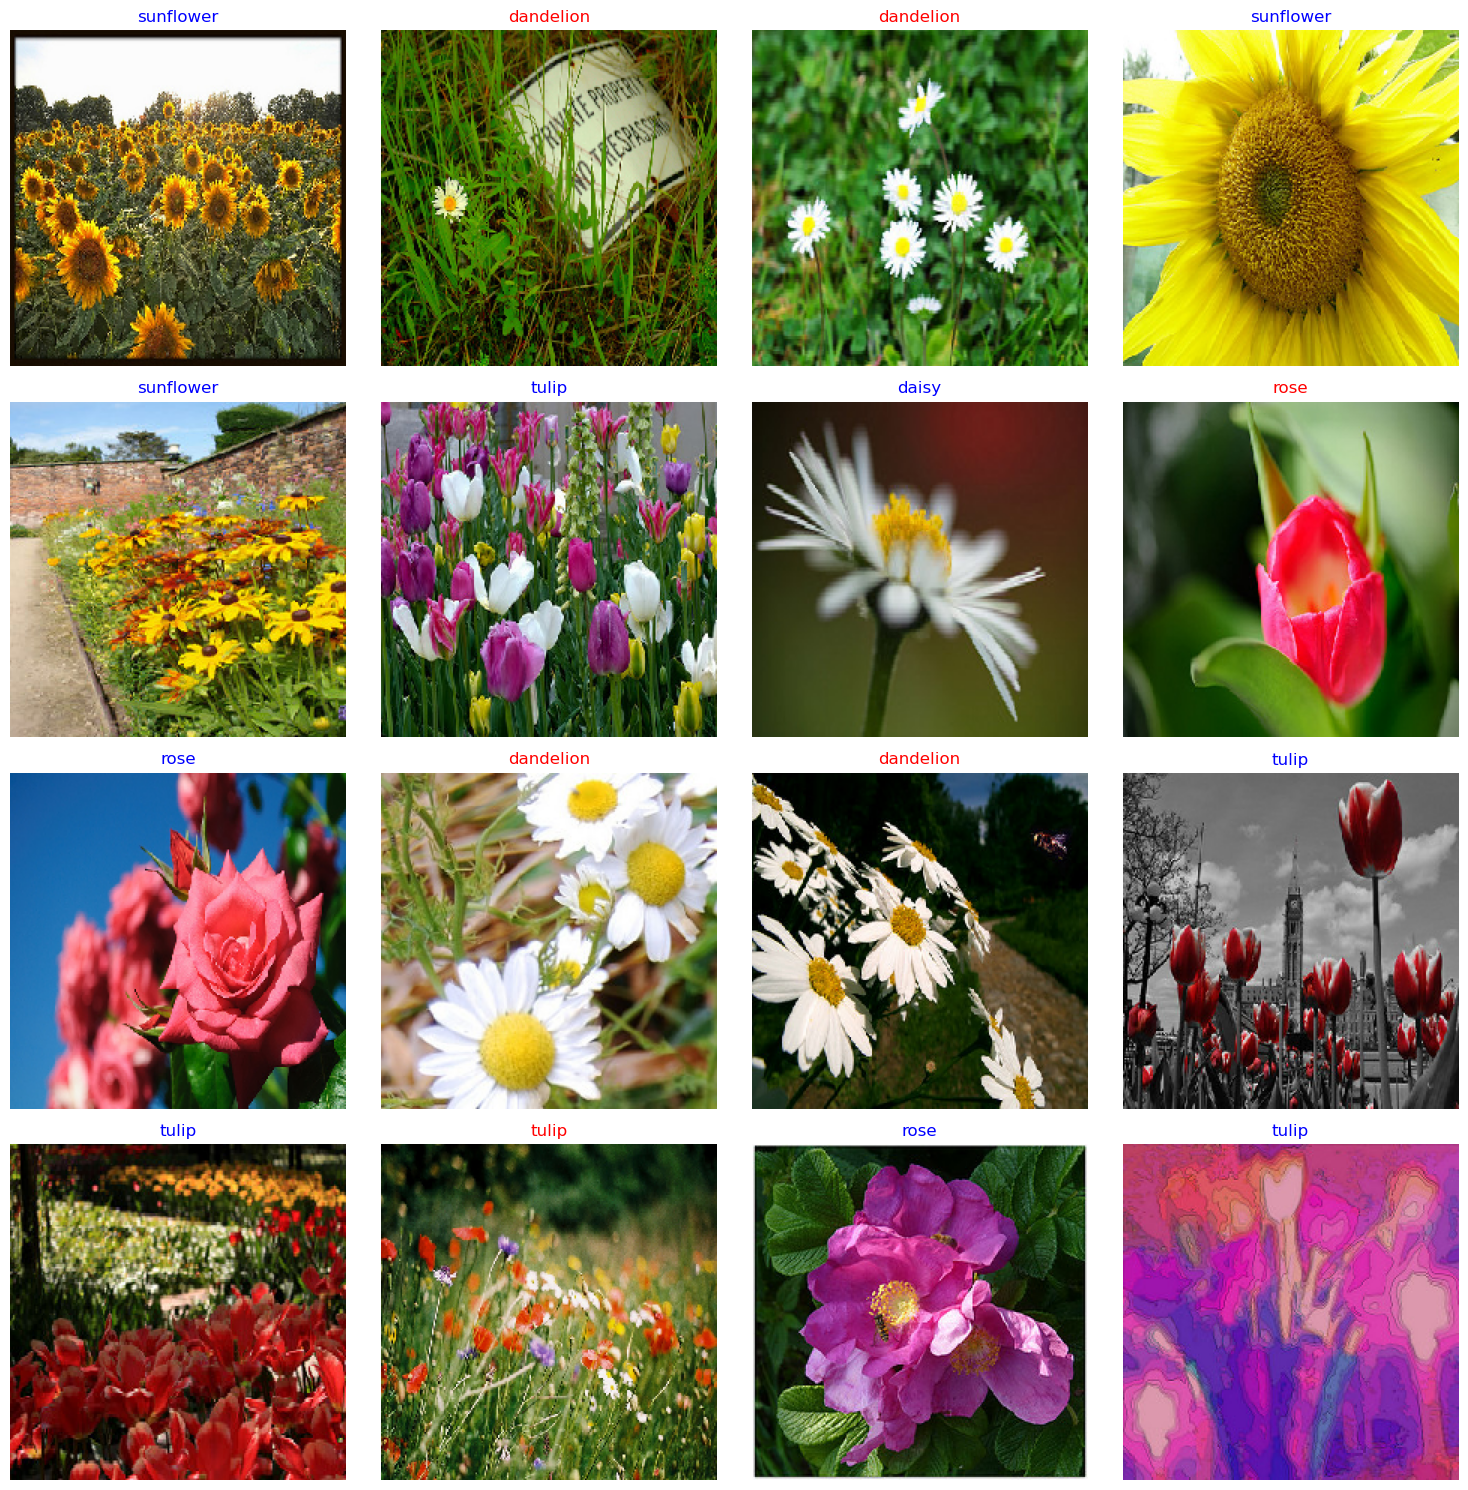

In [12]:
plot_predictions(test_generator, model, class_names)

In [13]:
transfer_layer = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
transfer_layer.trainable = False

In [14]:
transfer_model = tf.keras.Sequential([
    transfer_layer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [15]:
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 21,138,757
Trainable params: 6,424,069
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
transfer_model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/10
18/18 [==============================] - 34s 2s/step - loss: 7.4224 - accuracy: 0.2821 - val_loss: 3.5298 - val_accuracy: 0.5150
Epoch 2/10
18/18 [==============================] - 32s 2s/step - loss: 3.6869 - accuracy: 0.4536 - val_loss: 2.8745 - val_accuracy: 0.7000
Epoch 3/10
18/18 [==============================] - 32s 2s/step - loss: 2.7242 - accuracy: 0.6143 - val_loss: 2.3741 - val_accuracy: 0.7400
Epoch 4/10
18/18 [==============================] - 33s 2s/step - loss: 2.3764 - accuracy: 0.6143 - val_loss: 2.0777 - val_accuracy: 0.7100
Epoch 5/10
18/18 [==============================] - 33s 2s/step - loss: 2.0682 - accuracy: 0.6714 - val_loss: 1.7718 - val_accuracy: 0.7550
Epoch 6/10
18/18 [==============================] - 34s 2s/step - loss: 1.9300 - accuracy: 0.6429 - val_loss: 1.6179 - val_accuracy: 0.7800
Epoch 7/10
18/18 [==============================] - 33s 2s/step - loss: 1.7890 - accuracy: 0.6321 - val_loss: 1.5219 - val_accuracy: 0.8000
Epoch 8/10
18/18 [==

In [17]:
transfer_model.evaluate(test_generator)

13/13 [==============================] - 13s 1s/step - loss: 1.3126 - accuracy: 0.8200


[1.3125606775283813, 0.8199999928474426]

In [18]:
transfer_layer.trainable = True

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 21,138,757
Trainable params: 21,138,757
Non-trainable params: 0
_________________________________________________________________


In [ ]:
transfer_model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping]) 

Epoch 1/10
18/18 [==============================] - 88s 5s/step - loss: 1.4382 - accuracy: 0.7036 - val_loss: 1.1920 - val_accuracy: 0.8200
Epoch 2/10
18/18 [==============================] - 89s 5s/step - loss: 1.2826 - accuracy: 0.7643 - val_loss: 1.2565 - val_accuracy: 0.7650
Epoch 3/10
18/18 [==============================] - 90s 5s/step - loss: 1.2005 - accuracy: 0.7929 - val_loss: 1.0714 - val_accuracy: 0.8400
Epoch 4/10
18/18 [==============================] - 89s 5s/step - loss: 1.0803 - accuracy: 0.7964 - val_loss: 1.0008 - val_accuracy: 0.8550
Epoch 5/10
18/18 [==============================] - 89s 5s/step - loss: 1.0573 - accuracy: 0.8214 - val_loss: 0.9761 - val_accuracy: 0.8650
Epoch 6/10
18/18 [==============================] - 89s 5s/step - loss: 0.9324 - accuracy: 0.8679 - val_loss: 0.9590 - val_accuracy: 0.8550
Epoch 7/10
18/18 [==============================] - 88s 5s/step - loss: 0.9235 - accuracy: 0.8714 - val_loss: 0.9166 - val_accuracy: 0.8750
Epoch 8/10
18/18 [==

In [23]:
transfer_model.evaluate(test_generator)

13/13 [==============================] - 13s 980ms/step - loss: 0.5789 - accuracy: 0.9900


[0.5789464116096497, 0.9900000095367432]

1/1 [==============================] - 1s 1s/step


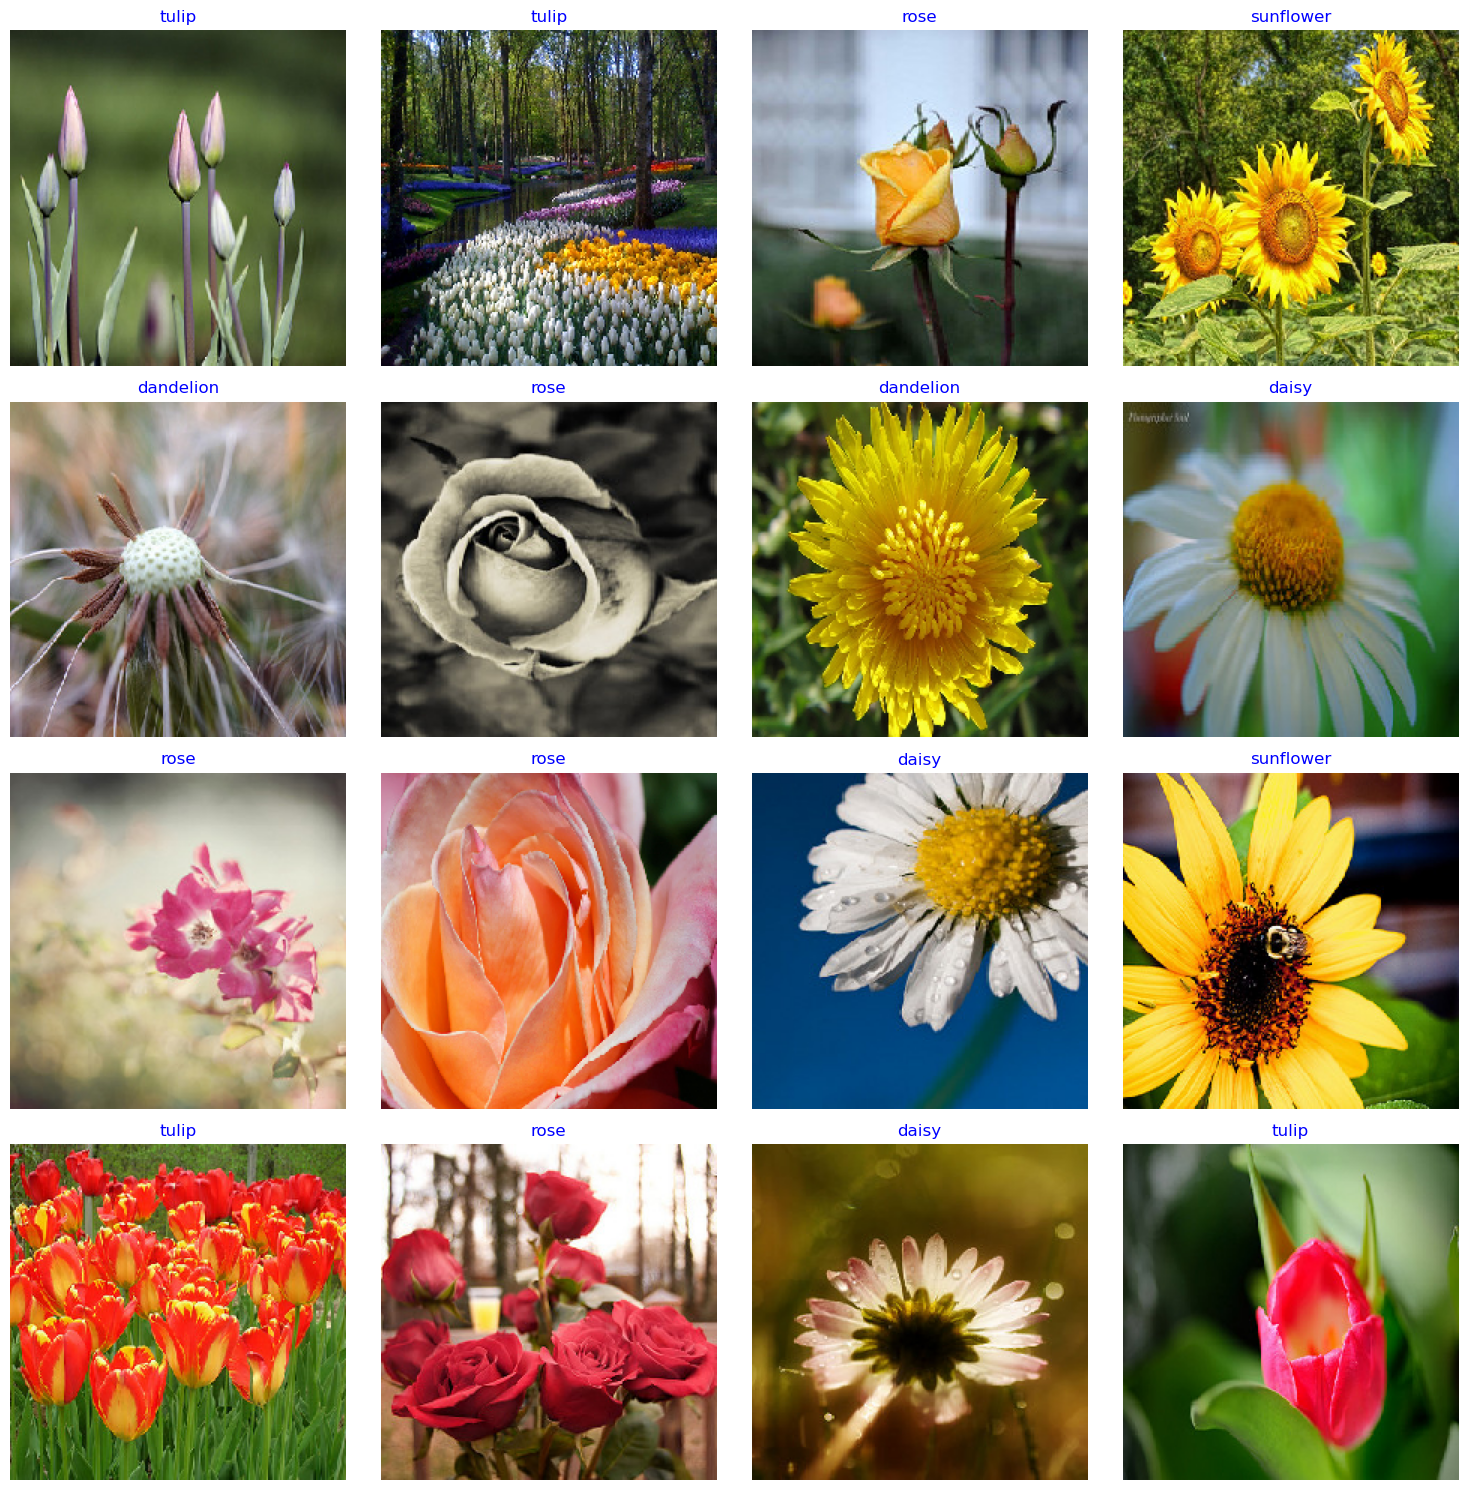

In [24]:
plot_predictions(test_generator, transfer_model, class_names)